In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('My First Spark application') \
    .getOrCreate() 

sc = spark.sparkContext
import plotly.graph_objects as go
import networkx as nx
import seaborn as sns
import numpy as np

In [2]:
Case = pd.read_csv('Case.csv')
PatientInfo = pd.read_csv('PatientInfo.csv')
Policy = pd.read_csv('Policy.csv')
Region = pd.read_csv('Region.csv')
SearchTrend = pd.read_csv('SearchTrend.csv')
SeoulFloating = pd.read_csv('SeoulFloating.csv')
Time = pd.read_csv('Time.csv')
TimeAge = pd.read_csv('TimeAge.csv')
TimeGender = pd.read_csv('TimeGender.csv')
TimeProvince = pd.read_csv('TimeProvince.csv')
Weather = pd.read_csv('Weather.csv')

# Age VS Confirmed cases

To begin with, I wanted to see which age group has the most confirmed cases.
So I created a simple bar chart that shows the accumulated confirmed cases in different age groups.

Text(0.5, 1.0, 'Accumulated confirmed case in different age groups')

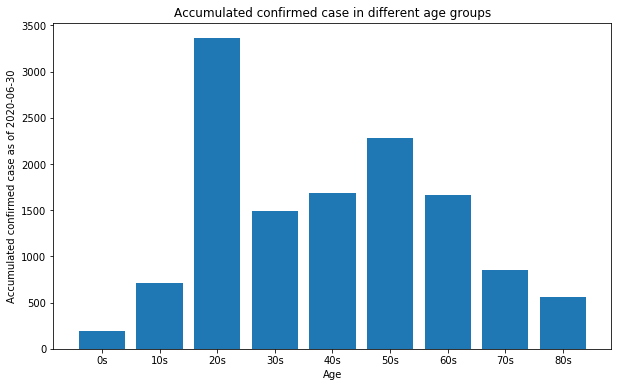

In [6]:
plt.figure(figsize = (10,6))
TimeAge = pd.read_csv('TimeAge.csv')
plt.bar(TimeAge[TimeAge.date == '2020-06-30']['age'],TimeAge[TimeAge.date == '2020-06-30']['confirmed'])
plt.xlabel('Age')
plt.ylabel('Accumulated confirmed case as of 2020-06-30')
plt.title('Accumulated confirmed case in different age groups')

we could see 20s has the highest confirmed cases followed by 50s

but why 20s though...?

At first, I thought it might have something to do with their lifestyle. So in Korea, there's this thing called ‘Bul Geum’, which is a word for representing a lifestyle where you enjoy night life every weekend, especially friday. Though, I am pretty sure there is a word for that in every other country.

To see if that is a valid point, first I brokedown the floating population of Seoul by age groups.

C:\Users\dy090\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


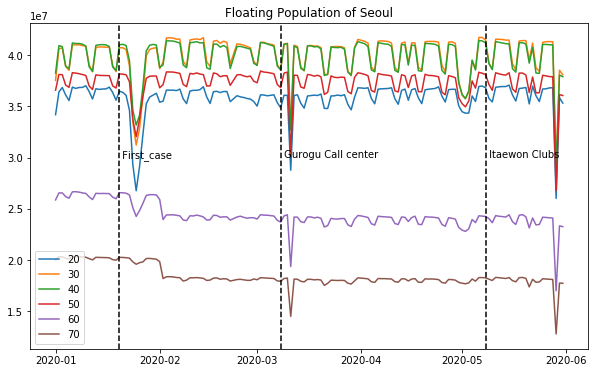

In [27]:
SeoulFloating = SeoulFloating[SeoulFloating.date != '2020-02-23'] # sorting out the noise
SB = SeoulFloating.groupby(['date','birth_year']).sum().reset_index()
SB.date = pd.to_datetime(SB.date)
by = SB.birth_year.unique()
plt.figure(figsize = (10,6))
for i in by:
    plt.plot(SB[SB.birth_year == i].date, SB[SB.birth_year == i].fp_num, label = i)
major_event = [pd.datetime(2020,1,20), pd.datetime(2020,3,8), pd.datetime(2020,5,8)]
major_event_text = [' First_case', ' Gurogu Call center', ' Itaewon Clubs']
for i in range(len(major_event)):
    plt.axvline(major_event[i], color = 'k', ls = '--')
    plt.annotate(major_event_text[i], xy = (major_event[i],30000000))
plt.title('Floating Population of Seoul')
plt.legend()

From the visualization, I found things like;
1. Floating population generally decreases on weekends.
2. There's a huge gap between the floating population of the 60s and 70s and that of the rest of the groups
3. Ever since the corona virus, the floating population of 60s and 70s had declined when there wasn't any trend in that of the rest of the groups
4. Between the age group of the 20s to 50s, it seems that the 20s and 50s' floating population has less gap between the weekdays and weekends, meaning that they are the ones that are relatively more active on weekends.

To mathematically measure the degree of gap between weekdays and weekends of each age group, I have calculated each group's floating population's standard deviation.

{20: 1649837.6794549678,
 30: 2041252.8382675091,
 40: 1898141.507092383,
 50: 1438199.4259757495,
 60: 1233844.7466128352,
 70: 1034540.1060866547}

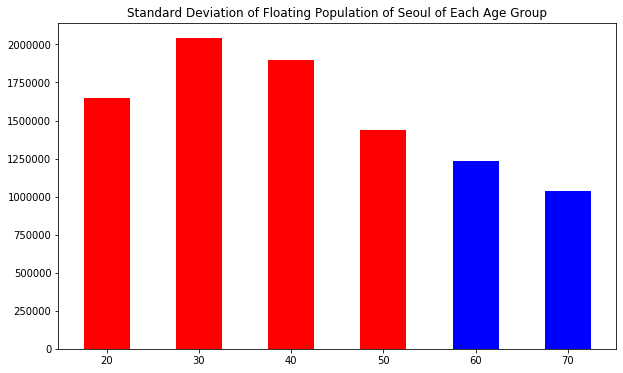

In [28]:
plt.figure(figsize = (10,6))
floating_std = {}
for i in by:
    floating_std[i] = SB[SB.birth_year == i].fp_num.std()

plt.bar(floating_std.keys(),floating_std.values(), width = 5, color = ['r']*4 + ['b']*2)
plt.title('Standard Deviation of Floating Population of Seoul of Each Age Group')
floating_std

So, it turns out that the 20s and 50s are more stable in terms of their floating population than the 30s and 40s. And they are the ones that have the higher confirmed cases. There might be a relation between the risk of getting the coronavirus and the lifestyle where you stay more active on weekends.

To do some further analysis, I decided to filter the cities that are famous for their night life facilities and the floating population of late hours to see if the 20s are actually enjoying their 'Bul Geum'.

Selected City:
- Gangnam-gu
- Mapo-gu
- Yongsan-gu

Selected hours:
- 23, 24, 0, 1, 2

In [ ]:
import pandasql as ps
q1 = """
Select * from SeoulFloating
where city in ('Gangnam-gu', 'Mapo-gu', 'Yongsan-gu')
and hour in (23,24,0,1,2)
"""
nightlife_cities = ps.sqldf(q1, locals())
nightlife_cities

Then, I have created the visualization that shows the average floating population of cities that are famous for their night life VS that of average Seoul.

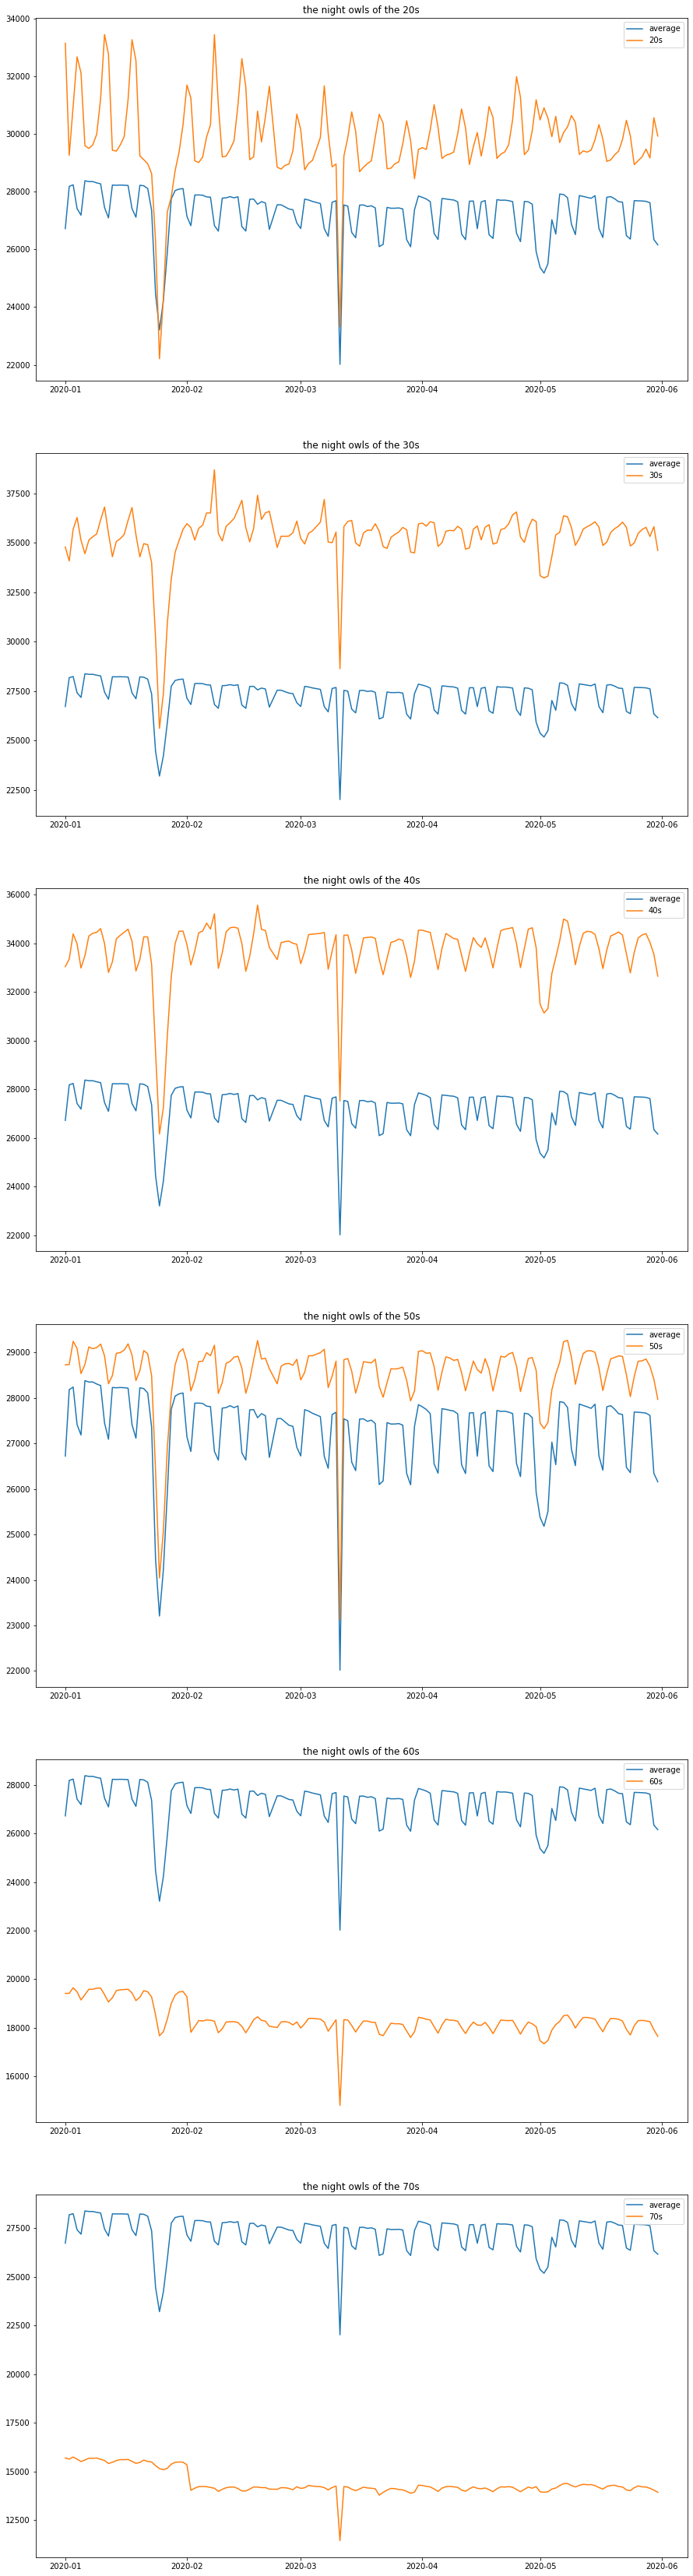

In [95]:
plt.figure(figsize = (15,60))
nightlife_cities.date = pd.to_datetime(nightlife_cities.date)
NSB = nightlife_cities.groupby(['date','birth_year']).mean().reset_index()
for i in range(6):
    plt.subplot(611 + i)
    plt.plot(SeoulFloating.groupby('date').mean().index, SeoulFloating.groupby('date').mean().fp_num, label = 'average')    
    plt.plot(NSB[NSB.birth_year == by[i]].date, NSB[NSB.birth_year == by[i]].fp_num, 
             label = '{}s'.format(by[i]))
    plt.title('the night owls of the {}s'.format(by[i]))
    plt.legend()

From the visualization, we can easily see that the floating population of the night owls of the 20s has pretty much the opposite trend than that of the average floating population.
To measure how different they are, I have created the correlation matrix

In [94]:
NSB.pivot(index = 'date',columns = 'birth_year')['fp_num'].corr()
NSBXSF = pd.merge(NSB.pivot(index = 'date',columns = 'birth_year')['fp_num'], 
        SeoulFloating.groupby('date').mean(),
        how = 'inner',
        left_on = NSB.pivot(index = 'date',columns = 'birth_year')['fp_num'].index,
        right_on = SeoulFloating.groupby('date').mean().index)
NSBXSF.drop(['hour','birth_year'],axis =1, inplace=True)
NSBXSF.rename({'fp_num':'average'},axis = 1,inplace = True)
NSBXSF.corr()

,20,30,40,50,60,70,average
20,1.000000,0.752655,0.515206,0.599362,0.300889,0.159624,0.253313
30,0.752655,1.000000,0.923738,0.893628,0.269981,-0.058025,0.639555
40,0.515206,0.923738,1.000000,0.961688,0.426667,0.072923,0.842002
50,0.599362,0.893628,0.961688,1.000000,0.571361,0.253880,0.862248
60,0.300889,0.269981,0.426667,0.571361,1.000000,0.929510,0.661714
70,0.159624,-0.058025,0.072923,0.253880,0.929510,1.000000,0.388239
average,0.253313,0.639555,0.842002,0.862248,0.661714,0.388239,1.000000


It is pretty obvious that the party people of 20s behave differently from other night owls. This might explains why 20s have so much confirmed cases